## Sentimental Analysis on Bitcoin wiki history

In [1]:
import mwclient
import time

site = mwclient.Site("en.wikipedia.org")
page = site.pages["Bitcoin"]

In [2]:
revs = list(page.revisions())

In [3]:
revs = sorted(revs, key=lambda rev: rev["timestamp"])
revs = revs[0:]

In [4]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

/Users/tiffany/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("best_of")
/Users/tiffany/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("repetition_penalty")
/Users/tiffany/opt/anaconda3/lib/python3.9/site-packages/huggingface_hu

In [5]:
def find_sentiment(text):
    sent = sentiment_pipeline([text[:250]])[0]
    score = sent["score"]
    if sent["label"] == "NEGATIVE":
        score *= -1
    return score

In [6]:
edits = {}

for rev in revs:
    date = time.strftime("%Y-%m-%d", rev["timestamp"])
    
    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0)
        
    edits[date]["edit_count"] += 1
    
    comment = rev.get("comment", "")
    edits[date]["sentiments"].append(find_sentiment(comment))

In [7]:
from statistics import mean

for key in edits:
    if len(edits[key]["sentiments"]) > 0:
        edits[key]["sentiment"] = mean(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s < 0])/ len(edits[key]["sentiments"])
        
    else:
        edits[key]["sentiment"] = 0
        edits[key]["neg_sentiments"] = 0
        
    del edits[key]["sentiments"]
    

In [8]:
import pandas as pd

edits_df = pd.DataFrame.from_dict(edits, orient="index")
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.750000
2009-08-05,1,0.748121,0.000000
2009-08-06,2,0.995746,0.000000
2009-08-14,1,0.930021,0.000000
2009-10-13,2,-0.227499,0.500000
...,...,...,...
2024-01-10,1,0.876925,0.000000
2024-01-11,1,0.924098,0.000000
2024-01-12,3,0.315349,0.333333
2024-01-15,2,0.080182,0.500000


In [9]:
edits_df.index = pd.to_datetime(edits_df.index)

In [10]:
from datetime import datetime

dates = pd.date_range(start="2009-03-08", end="2022-09-08")

In [11]:
dates

DatetimeIndex(['2009-03-08', '2009-03-09', '2009-03-10', '2009-03-11',
               '2009-03-12', '2009-03-13', '2009-03-14', '2009-03-15',
               '2009-03-16', '2009-03-17',
               ...
               '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02',
               '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06',
               '2022-09-07', '2022-09-08'],
              dtype='datetime64[ns]', length=4933, freq='D')

In [12]:
edits_df = edits_df.reindex(dates, fill_value=0)

In [13]:
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.75
2009-03-09,0,0.000000,0.00
2009-03-10,0,0.000000,0.00
2009-03-11,0,0.000000,0.00
2009-03-12,0,0.000000,0.00
...,...,...,...
2022-09-04,0,0.000000,0.00
2022-09-05,0,0.000000,0.00
2022-09-06,1,0.809337,0.00
2022-09-07,0,0.000000,0.00


In [14]:
rolling_edits=edits_df.rolling(30).mean()

In [15]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2009-03-08,NaN,NaN,NaN
2009-03-09,NaN,NaN,NaN
2009-03-10,NaN,NaN,NaN
2009-03-11,NaN,NaN,NaN
2009-03-12,NaN,NaN,NaN
...,...,...,...
2022-09-04,0.400000,-0.108480,0.150000
2022-09-05,0.400000,-0.108480,0.150000
2022-09-06,0.433333,-0.081502,0.150000
2022-09-07,0.433333,-0.081502,0.150000


In [16]:
rolling_edits = rolling_edits.dropna()

## Price Predition

In [17]:
import yfinance as yf
import os
import pandas as pd
import datetime as dt

In [18]:
btc_ticker = yf.Ticker("BTC-USD")

In [19]:
btc = btc_ticker.history(period="max")

In [20]:
btc.index = pd.to_datetime(btc.index)
btc.index = btc.index.tz_localize(None)
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-17,43132.101562,43189.890625,42189.308594,42742.652344,20851232595,0.0,0.0
2024-01-18,42742.312500,42876.347656,40631.171875,41262.058594,25218357242,0.0,0.0
2024-01-19,41278.460938,42134.160156,40297.457031,41618.406250,25752407154,0.0,0.0


In [21]:
del btc["Dividends"]
del btc["Stock Splits"]

In [22]:
btc.columns = [c.lower() for c in btc.columns]

<Axes: xlabel='Date'>

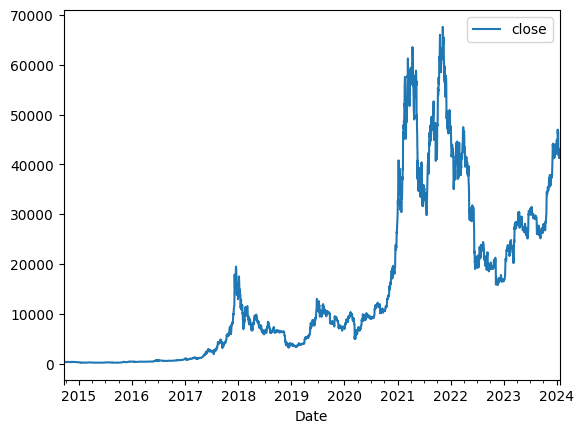

In [23]:
btc.plot.line(y="close", use_index=True)

In [24]:
wiki = rolling_edits

In [25]:
btc = btc.merge(wiki, left_index=True, right_index=True)
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232759,0.532718
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718
...,...,...,...,...,...,...,...,...
2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,25245861652,0.400000,-0.108480,0.150000
2022-09-05,19988.789062,20031.160156,19673.046875,19812.371094,28813460025,0.400000,-0.108480,0.150000
2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,43403978910,0.433333,-0.081502,0.150000
2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,35239757134,0.433333,-0.081502,0.150000


In [26]:
btc["tomorrow"] = btc["close"].shift(-1)

In [27]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232759,0.532718,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008
...,...,...,...,...,...,...,...,...,...
2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,25245861652,0.400000,-0.108480,0.150000,19812.371094
2022-09-05,19988.789062,20031.160156,19673.046875,19812.371094,28813460025,0.400000,-0.108480,0.150000,18837.667969
2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,43403978910,0.433333,-0.081502,0.150000,19290.324219
2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,35239757134,0.433333,-0.081502,0.150000,19329.833984


In [28]:
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)

In [29]:
btc["target"].value_counts()

target
1    1563
0    1351
Name: count, dtype: int64

## Building Model

In [32]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = btc.iloc[:-200]
test = btc[-200:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["target"])


RandomForestClassifier(min_samples_split=50, random_state=1)

In [35]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"],preds)


0.48484848484848486

In [44]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"],preds], axis=1)
    return combined

def backtest(data, model, predictor, start=1095, step=150):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy() ## 0 to i [0:start], [0:start+250]
        test = data.iloc[i:(i+step)].copy() # i to i+250 [start:start+250], [start+250, start+250+250]
        predictions = predict(train, test, predictor, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [ ]:
## upgrade to XGboost

In [45]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(btc, model, predictors)

In [46]:
precision_score(predictions["target"],predictions["predictions"])

0.5171102661596958

In [57]:
## improve accuracy, generate new predictor

def compute_rolling(btc):
    horizons = [2,7,60,365]
    new_predictors =["close","sentiment","neg_sentiment"]
    
    for horizon in horizons:
        rolling_averages = btc.rolling(horizon, min_periods=1).mean()
        
        ratio_column = f"close_ration_{horizon}"
        btc[ratio_column] = btc["close"]/ rolling_averages["close"]
        
        edit_column = f"edit_{horizon}"
        btc[edit_column] = rolling_averages["edit_count"]
        
        rolling = btc.rolling(horizon, closed="left", min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        btc[trend_column] = rolling["target"]
        
        new_predictors += [ratio_column, trend_column, edit_column]
        
    return btc, new_predictors

In [58]:
btc, new_predictors = compute_rolling(btc.copy())

In [59]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target,...,trend_2,close_ration_7,edit_7,trend_7,close_ration_60,edit_60,trend_60,close_ration_365,edit_365,trend_365
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0,...,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232759,0.532718,394.795990,0,...,0.0,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1,...,0.0,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0,...,0.5,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1,...,0.5,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,25245861652,0.400000,-0.108480,0.150000,19812.371094,0,...,0.5,0.998906,0.342857,0.571429,0.906969,0.270556,0.433333,0.505329,0.891050,0.482192
2022-09-05,19988.789062,20031.160156,19673.046875,19812.371094,28813460025,0.400000,-0.108480,0.150000,18837.667969,0,...,0.5,0.993637,0.357143,0.428571,0.900301,0.267222,0.416667,0.502031,0.890776,0.479452
2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,43403978910,0.433333,-0.081502,0.150000,19290.324219,1,...,0.0,0.951291,0.376190,0.428571,0.857889,0.264444,0.400000,0.478456,0.890594,0.476712
2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,35239757134,0.433333,-0.081502,0.150000,19329.833984,1,...,0.5,0.979516,0.395238,0.428571,0.880041,0.262222,0.416667,0.490893,0.889954,0.479452


In [60]:
predictions = backtest(btc, model, new_predictors)
precision_score(predictions["target"],predictions["predictions"])

0.5240328253223916

In [61]:
predictions

,target,predictions
2017-09-16,0,0
2017-09-17,1,1
2017-09-18,0,0
2017-09-19,0,1
2017-09-20,0,1
...,...,...
2022-09-04,0,1
2022-09-05,0,1
2022-09-06,1,1
2022-09-07,1,1


In [ ]:
##Improvement
#sentimental value: twitter
#other metrics to factor in: interest rate, other currency exchange
# https://www.youtube.com/watch?v=TF2Nx_ifmrU